<a href="https://colab.research.google.com/github/Aayushg416/ProjectsIITB/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Data Loading & Preprocessing**

In [1]:
# 📦 Install dependencies (if not already done)
!pip install transformers datasets -q
from datasets import load_dataset
from transformers import AutoTokenizer
import torch

# 📥 Load Amazon Polarity dataset
dataset = load_dataset("amazon_polarity")

# 🔤 Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# 💡 To avoid RAM issues, take a smaller random subset
# ~50k training and 10k test examples (enough for fine-tuning)
small_train = dataset["train"].shuffle(seed=42).select(range(50000))
small_test = dataset["test"].shuffle(seed=42).select(range(10000))

# ✂️ Tokenization function
def tokenize_fn(example):
    return tokenizer(
        example["content"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# 🧼 Apply tokenization (batched for efficiency)
tokenized_train = small_train.map(tokenize_fn, batched=True)
tokenized_test = small_test.map(tokenize_fn, batched=True)

# 🏷️ Rename 'label' to 'labels' for Trainer compatibility
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_test = tokenized_test.rename_column("label", "labels")

# 🔁 Format for PyTorch
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# 🔀 Split training into train (90%) and validation (10%)
train_val_split = tokenized_train.train_test_split(test_size=0.1)
train_dataset = train_val_split["train"]
val_dataset = train_val_split["test"]
test_dataset = tokenized_test

print(f"✅ Train size: {len(train_dataset)}")
print(f"✅ Validation size: {len(val_dataset)}")
print(f"✅ Test size: {len(test_dataset)}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

amazon_polarity/train-00000-of-00004.par(…):   0%|          | 0.00/260M [00:00<?, ?B/s]

amazon_polarity/train-00001-of-00004.par(…):   0%|          | 0.00/258M [00:00<?, ?B/s]

amazon_polarity/train-00002-of-00004.par(…):   0%|          | 0.00/255M [00:00<?, ?B/s]

amazon_polarity/train-00003-of-00004.par(…):   0%|          | 0.00/254M [00:00<?, ?B/s]

amazon_polarity/test-00000-of-00001.parq(…):   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

✅ Train size: 45000
✅ Validation size: 5000
✅ Test size: 10000


# **2. Model Setup**

In [2]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **3. Training Setup**

In [3]:
import transformers
print(transformers.__version__)
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 🧮 Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# ⚙️ Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Changed from evaluation_strategy
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
)

# 🏋️ Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

4.57.1


# **4. Fine-Tuning**

In [4]:
# Use a smaller subset for quick training
small_train = train_dataset.select(range(10000))
small_val = val_dataset.select(range(5000))

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_val,
    compute_metrics=compute_metrics
)

trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aayushg416 (aayushg416-indian-institute-of-technology-bomaby) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.295000,0.245643,0.913400,0.938415,0.882544,0.909622
2,0.152900,0.326162,0.914600,0.917075,0.909275,0.913158


TrainOutput(global_step=1250, training_loss=0.20032584075927734, metrics={'train_runtime': 868.4464, 'train_samples_per_second': 23.03, 'train_steps_per_second': 1.439, 'total_flos': 1315555276800000.0, 'train_loss': 0.20032584075927734, 'epoch': 2.0})

# **5. Plotting Loss**

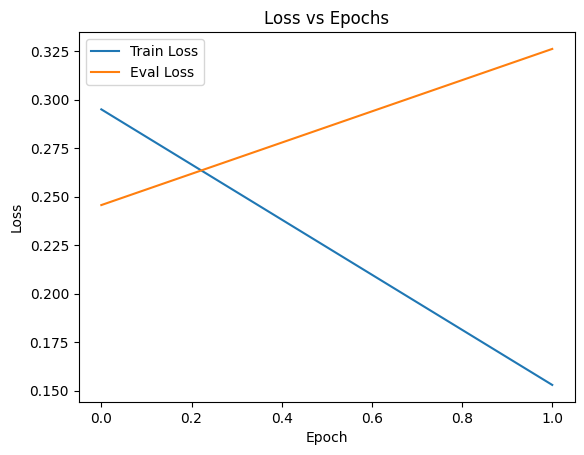

In [5]:
import matplotlib.pyplot as plt

# Extract logs
logs = trainer.state.log_history
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]

# Plot
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.show()


# **6.Final Evaluation on Test Set**

In [6]:
metrics = trainer.evaluate(test_dataset)
print("📊 Final Test Evaluation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


📊 Final Test Evaluation Metrics:
eval_loss: 0.2848
eval_accuracy: 0.9256
eval_precision: 0.9305
eval_recall: 0.9213
eval_f1: 0.9259
eval_runtime: 71.1738
eval_samples_per_second: 140.5010
eval_steps_per_second: 8.7810
epoch: 2.0000


# **7.Confusion Matrix Visualization**

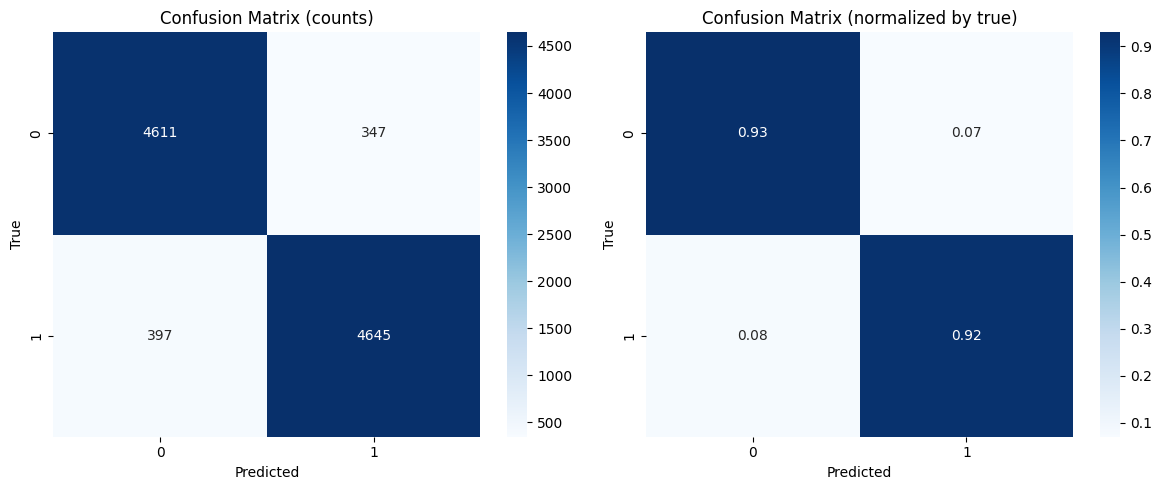


Classification report:

              precision    recall  f1-score   support

           0     0.9207    0.9300    0.9253      4958
           1     0.9305    0.9213    0.9259      5042

    accuracy                         0.9256     10000
   macro avg     0.9256    0.9256    0.9256     10000
weighted avg     0.9256    0.9256    0.9256     10000



In [7]:
# Step 7: Confusion matrix for test set (paste & run)
# Requirements: trainer (Trainer), test_dataset (Dataset), sklearn, seaborn, matplotlib

!pip install -q seaborn scikit-learn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1) Get predictions from the Trainer (returns pred logits, labels, metrics)
pred_output = trainer.predict(test_dataset)
logits = pred_output.predictions
if logits is None:
    raise RuntimeError("trainer.predict returned no predictions. Ensure trainer and test_dataset are defined and valid.")
preds = np.argmax(logits, axis=-1)
labels = pred_output.label_ids

# 2) Confusion matrix (counts) and normalized (by true labels)
cm = confusion_matrix(labels, preds)
cm_norm = confusion_matrix(labels, preds, normalize='true')  # rows sum to 1

# 3) Plot side-by-side: counts and normalized
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix (counts)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1])
axes[1].set_title("Confusion Matrix (normalized by true)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

# 4) Optional: show classification report (precision/recall/F1) for more insight
print("\nClassification report:\n")
print(classification_report(labels, preds, digits=4))
